# Preparation

In [2]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error, mean_squared_log_error


%matplotlib inline

In [3]:
df = pd.read_csv('data/hourly_data.csv')   # upload the dataset
df.Timestamp = pd.to_datetime(df.Timestamp)   # convert timestamp into datetime
df.set_index('Timestamp', inplace = True)   # convert 'Timestamp' column into index
temp_df = df['WS600 Temperature'].to_frame() # convert pandas series into Dataframe
temp_df.columns = ['Temperature']    # rename the column

In [4]:
# creating a function for interactive plotting using plotly

def plotly_plot(df, columns, title = ''):
    fig = go.Figure()
    for column in columns:
        fig.add_trace(go.Scatter(x=df.index, y=df[column], name=column))
    
    fig.update_layout(title_text=title,
                  xaxis_rangeslider_visible=True)
    #fig.show()
    iplot(fig)

In [5]:
plotly_plot(temp_df, ['Temperature'], 'Ambient Hourly Temperature')

Some data is missing and might be inreliable after October 21st due to equimpent mulfunctions. Therefore, the dataset is reduced and divided into train and test datasets. The forecast will be done for 24 hours. Thus, the test set contains the most recent 24 hours of data.

In [6]:
temp_df = temp_df[temp_df.index < '2019-10-21']
train_temp = temp_df.iloc[:-24]
test_temp = temp_df.iloc[-24:]

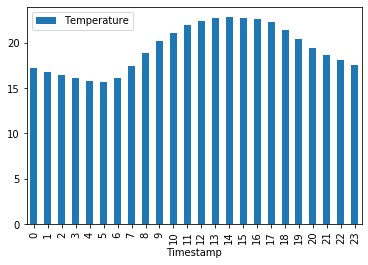

In [7]:
temp_df.groupby(temp_df.index.hour).mean().plot.bar()

It can be seen from this and the previous plots that the temperature is periodical with max around 14:00 and min - 5:00. Periodicity of the dataset is obviously 24 hours. Therefore, we can use statistical models based on the information about periodicity. For example, Holt-Winters method or triple exponential smoothing which has an additional component - seasonality.

# 0. Train and validation preparaion

# 1. Holt-Winters

In [22]:
from holt_winters import HoltWinters

In [23]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    num_splits = int(len(series)/slen)
    tscv = TimeSeriesSplit(n_splits=num_splits) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
        
    return np.mean(np.array(errors))

In [12]:
%%time
data = train_temp.Temperature 
periodicity = 24

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 24 hours
model = HoltWinters(data, slen = periodicity, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24, scaling_factor = 3)
model.triple_exponential_smoothing()

0.07649460494653787 0.0013038945284983283 0.042314458921607345
Wall time: 7min 6s


In [13]:
# model accuracy metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
hw_pred = model.result
hw_forecast = hw_pred[-periodicity:]

In [15]:
def plot_train_hw(series, plot_intervals=False, plot_anomalies=False):
    """
        series - train dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

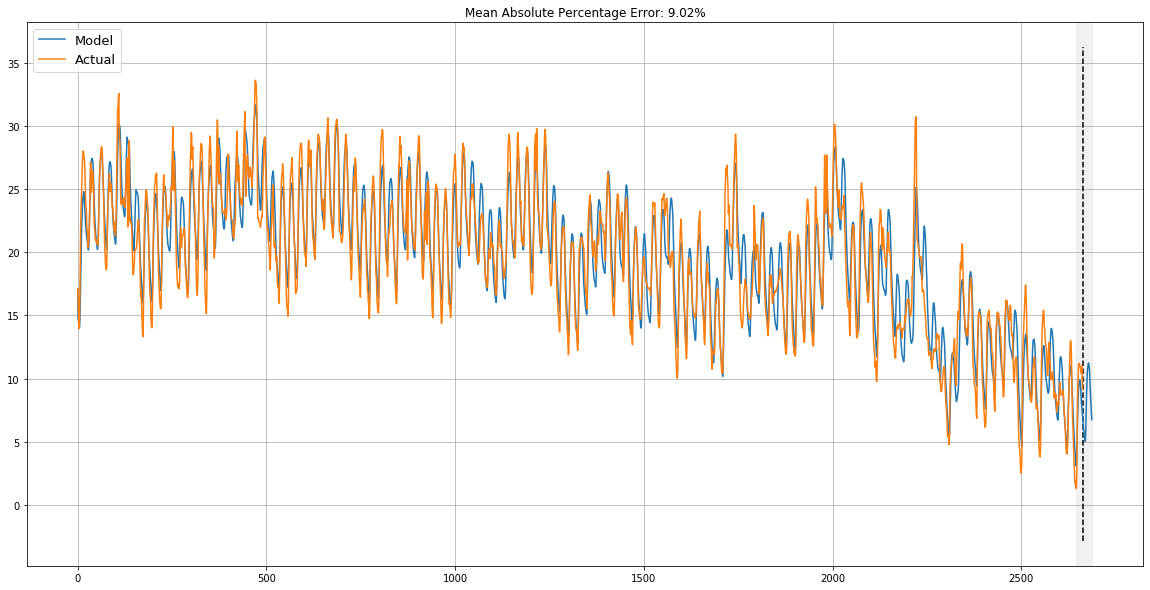

In [16]:
plot_train_hw(train_temp.Temperature)

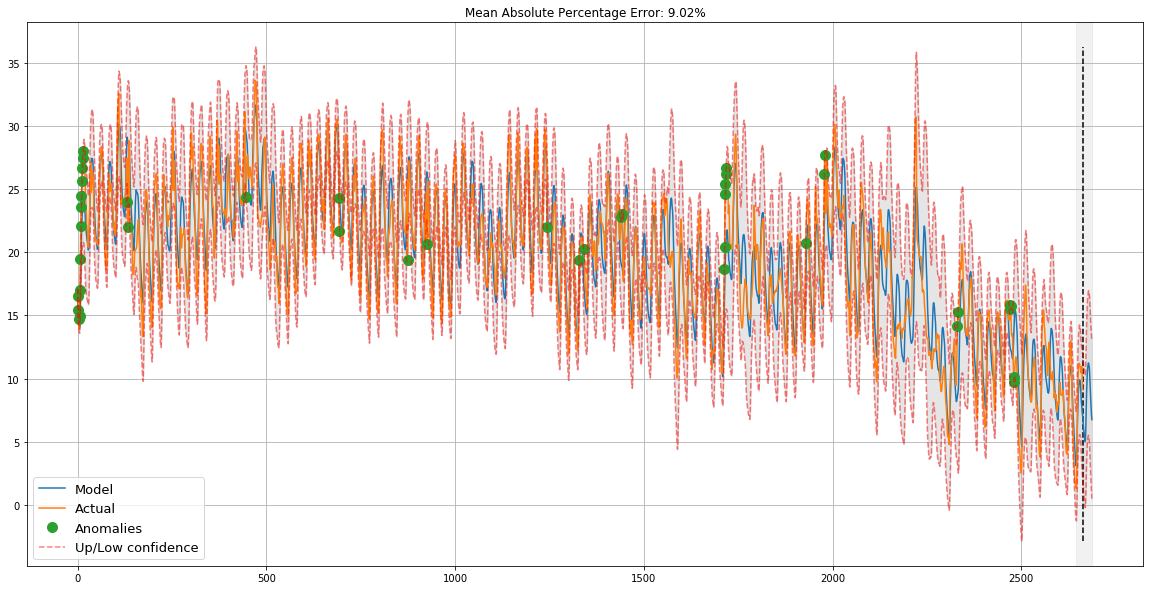

In [17]:
plot_train_hw(train_temp.Temperature, True, True)

In [18]:
def plot_forecast_hw(test, forecast, plot_intervals=False):
    
    plt.figure(figsize=(20, 10))
    plt.plot(forecast, label = "Forecast")
    plt.plot(test.values, label = "Actual")
    error = mean_absolute_percentage_error(test.values, forecast)
    plt.title("Mean Absolute Percentage Error of the Forecast: {0:.2f}%".format(error))
    
    if plot_intervals:
        plt.plot(model.UpperBond[-len(test):], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond[-len(test):], "r--", alpha=0.5)
        #plt.fill_between(x=range(0,len(test)), y1=model.UpperBond[:len(test)], 
        #                 y2=model.LowerBond[:len(test)], alpha=0.2, color = "grey") 
    
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

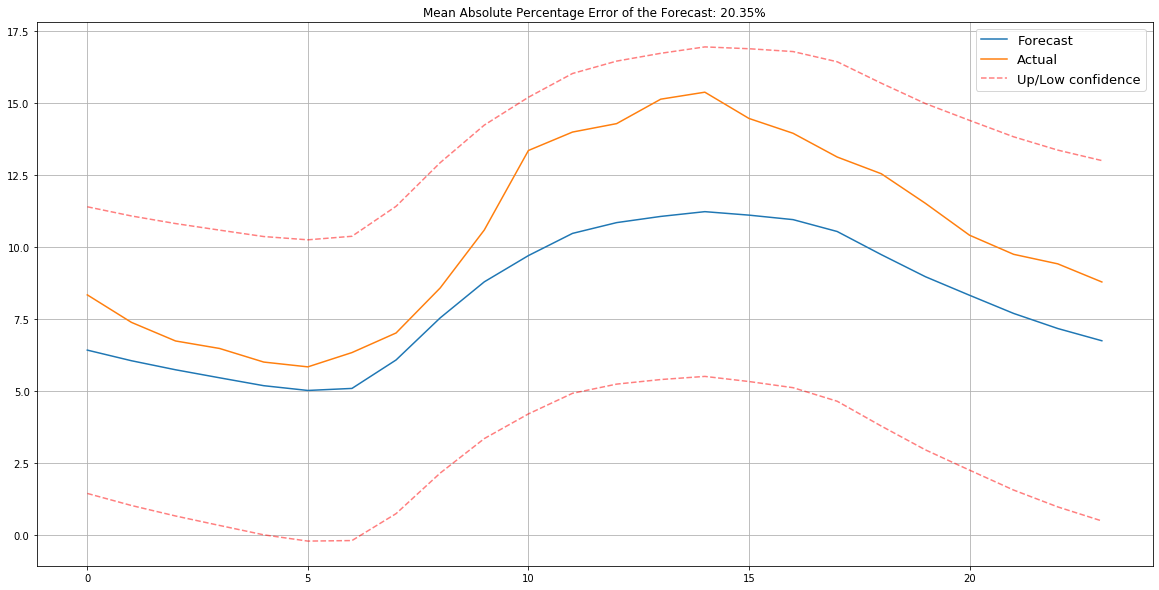

In [19]:
plot_forecast_hw(test_temp.Temperature, hw_forecast, True)

### Train the model on the data from the last 2 weeks

In [36]:
%%time
data = train_temp.Temperature[-900:] 
periodicity = 24

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 24 hours

model = HoltWinters(data, slen = periodicity, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24, scaling_factor = 3)
model.triple_exponential_smoothing()


0.06353843146325655 0.006782460649265576 0.0
Wall time: 35.5 s


In [37]:
hw_pred = model.result
hw_forecast = hw_pred[-periodicity:]

ValueError: operands could not be broadcast together with shapes (2664,) (924,) 

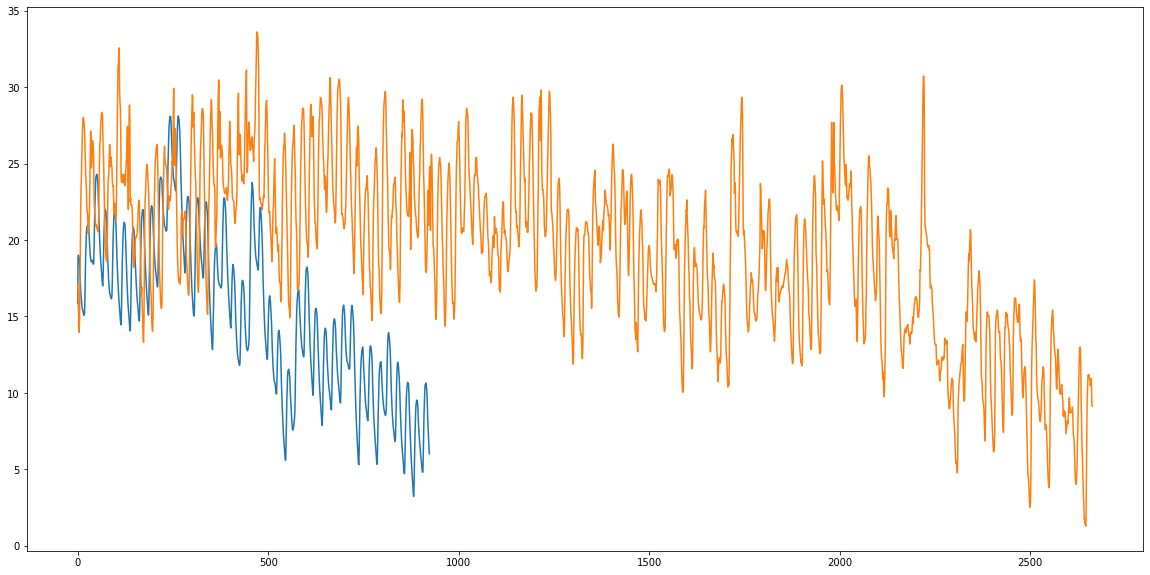

In [38]:
plot_train_hw(train_temp.Temperature, True, True)

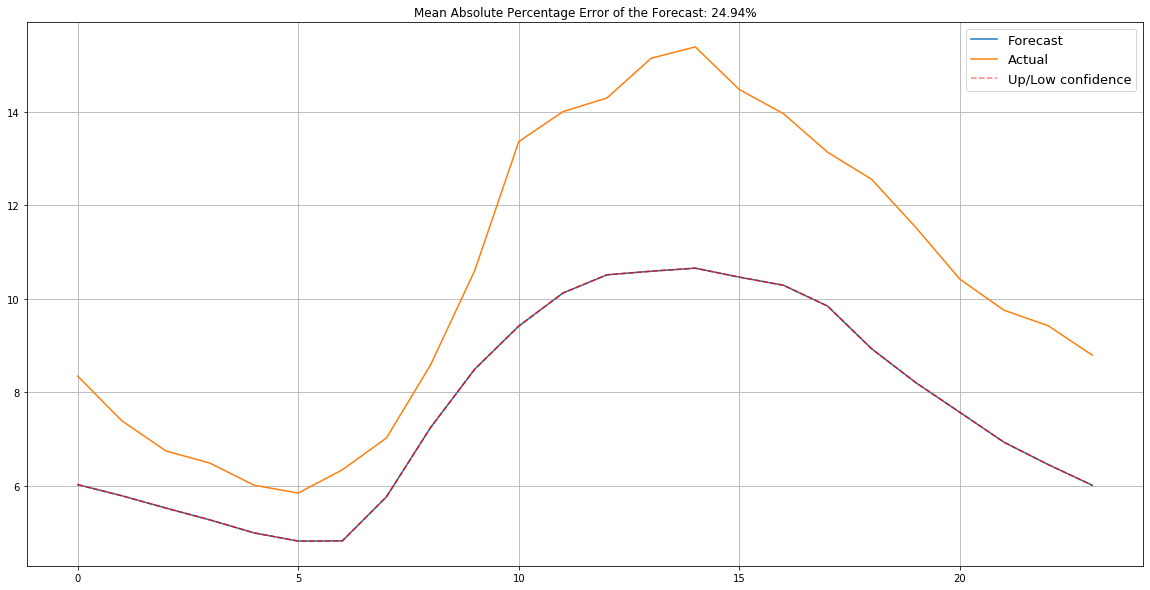

In [39]:
plot_forecast_hw(test_temp.Temperature, hw_forecast, True)

# 2. SARIMA

In [39]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

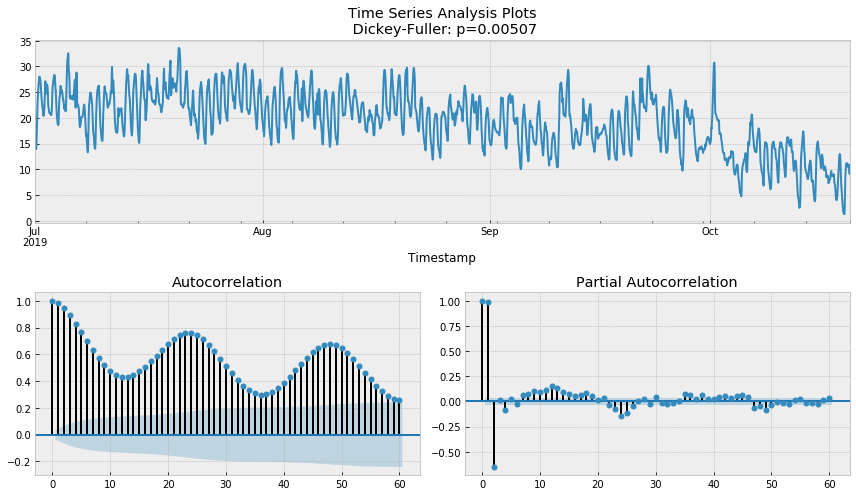

In [41]:
tsplot(train_temp.Temperature, lags=60)

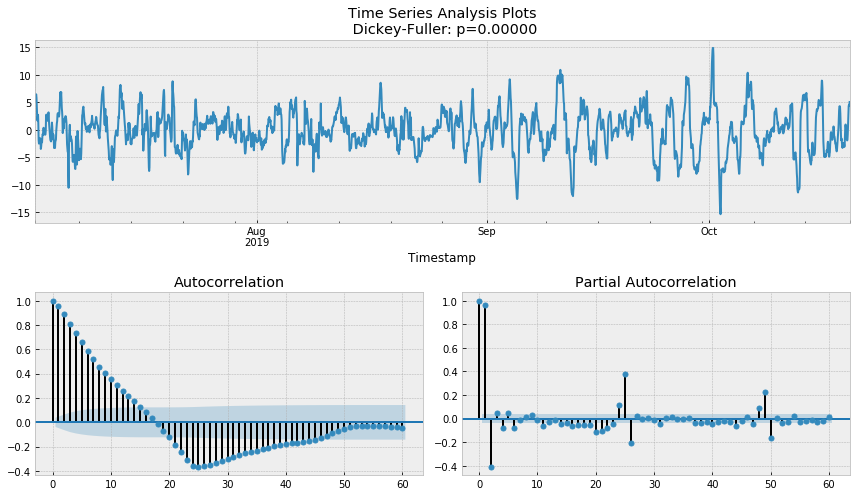

In [42]:
temperature = train_temp.Temperature
temp_diff = temperature - temperature.shift(24)
tsplot(temp_diff[24:], lags=60)

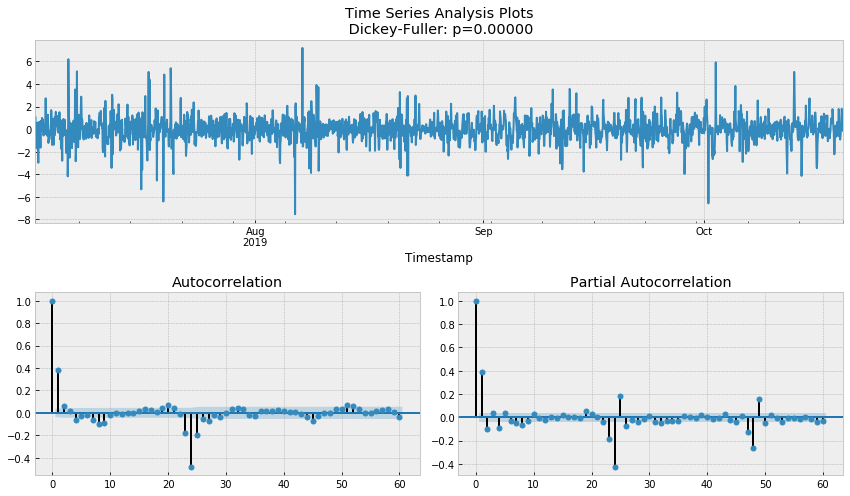

In [43]:
temp_diff = temp_diff - temp_diff.shift(1)
tsplot(temp_diff[24+1:], lags=60)

In [44]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [45]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(train_temp.Temperature, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [46]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimizatio

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so infe


Wall time: 34min 10s


In [47]:
result_table.head()

parameters          aic
0  (3, 2, 0, 1)  5585.313203
1  (3, 2, 1, 1)  5585.366326
2  (2, 4, 1, 1)  5585.624082
3  (4, 2, 1, 1)  5586.400361
4  (2, 4, 0, 1)  5586.618691

In [49]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(train_temp.Temperature, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                 Statespace Model Results                                 
Dep. Variable:                        Temperature   No. Observations:                 2664
Model:             SARIMAX(3, 1, 2)x(0, 1, 1, 24)   Log Likelihood               -2785.657
Date:                            Tue, 31 Dec 2019   AIC                           5585.313
Time:                                    00:51:50   BIC                           5626.460
Sample:                                07-01-2019   HQIC                          5600.211
                                     - 10-19-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7513      0.098      7.642      0.000       0.559       0.944
ar.L2          0.3769      0.143   

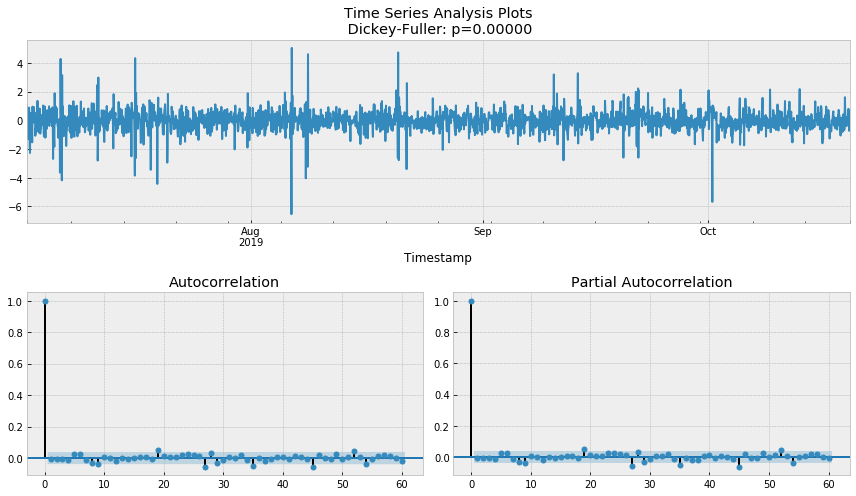

In [50]:
tsplot(best_model.resid[24+1:], lags=60)

In [51]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

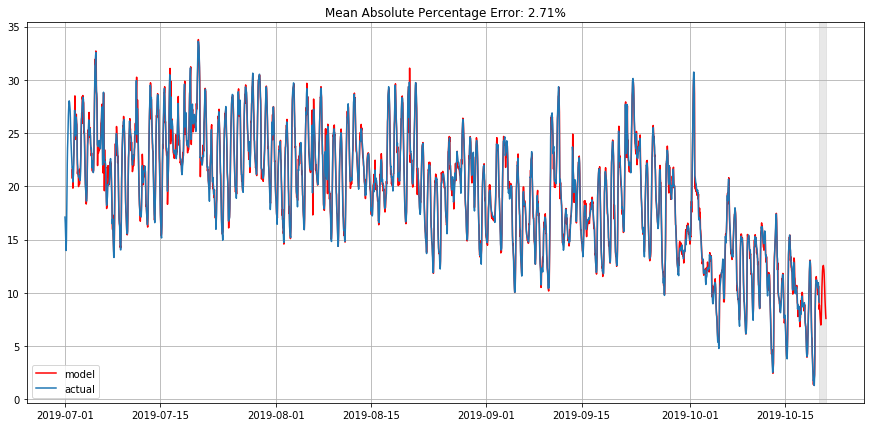

In [81]:
plotSARIMA(train_temp, best_model, 23)

In [82]:
sarima_forecast = best_model.predict(start = train_temp.shape[0], end = train_temp.shape[0]+23)

In [83]:
sarima_forecast.shape

(24,)

In [99]:
def plot_forecast_sarima(test, forecast):
    
    plt.figure(figsize=(15, 7))
    plt.figure(figsize=(15, 7))
    error = mean_absolute_percentage_error(test.values, forecast.values)
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.plot(test, label="actual")
    plt.legend()
    plt.grid(True);

<Figure size 1080x504 with 0 Axes>

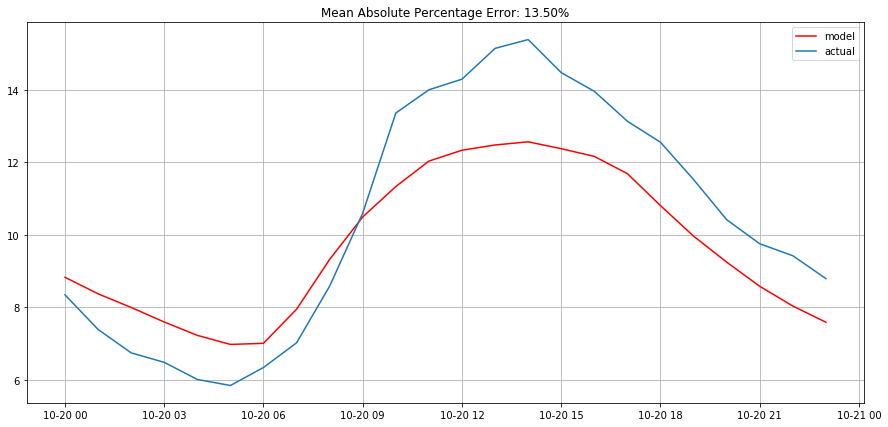

In [100]:
plot_forecast_sarima(test_temp.Temperature, sarima_forecast);